### Quantification table for PAR-2 and RING mutant alleles

- Compiling quantification data into a table
- Quantification data generated using _Run/par2_nebd_quantify.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties

from src import bounded_mean_1d, nb_setup

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

2023-12-20 20:58:20.628358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Filter relevant data
lines = ["lp637", "nwg240", "nwg338", "nwg201", "nwg246", "nwg369", "nwg374"]
df = df[
    df.Line.isin(lines) & (df.Line != "nwg374") & (df.RNAi == "wt")
    | ((df.Line == "nwg374") & (df.RNAi.str.contains("pkc")))
]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Perform summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    mem_frac = mem_tot / ((cyt / 0.174) + mem_tot)
    ratio_post = mem_post / cyt
    dosage = cyt + (mem_tot * 0.174)
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
            "Ratio post": ratio_post,
            "Mem frac": mem_frac,
            "Dosage": dosage,
        }
    )


df_summary = (
    df_quantification.groupby("EmbryoID").apply(calculate_summary).reset_index()
)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add genotype column
genotype_dict = {
    "lp637": "PAR-2(WT)",
    "nwg201": "PAR-2(WT); par-3(it71)",
    "nwg240": "PAR-2(C56S)",
    "nwg246": "PAR-2(C56S); par-3(it71)",
    "nwg338": "PAR-2(L109R)",
    "nwg369": "PAR-2(L109R); par-3(it71)",
    "nwg374": "PAR-2(S241A); pkc-3 RNAi",
}
df["Genotype"] = df["Line"].map(genotype_dict)

# Normalise
norm = df[df.Line == "lp637"].Cyt.mean()
for col in ["Cyt", "Mem_tot", "Mem_ant", "Mem_post", "Dosage"]:
    df[col] /= norm

### Full table

In [3]:
def create_table(df):
    # Define a dictionary to map old column names to new column names
    column_names = {
        "Cyt": "Normalised cytoplasmic\nconcentration (μm" + r"$^{-3}$" + ")",
        "Mem_post": "Normalised posterior membrane\nconcentration (μm"
        + r"$^{-2}$"
        + ")",
        "Ratio post": "Posterior M:C\nratio (μm)",
        "Mem frac": "Fraction at\nmembrane",
        "Dosage": "Total expression\n(μm" + r"$^{-3}$" + ")",
    }

    # Initialize an empty DataFrame for the results
    RESULTS = pd.DataFrame()

    # Loop over each column name
    for old_name, new_name in column_names.items():
        # Calculate the mean and standard deviation for the column
        mean = df.groupby("Genotype")[old_name].mean()
        std = df.groupby("Genotype")[old_name].std()

        # Format the results and add them to the DataFrame
        RESULTS[new_name] = mean.map("{:.2f}".format) + " ± " + std.map("{:.2f}".format)

    # Sort the DataFrame by genotype
    RESULTS = RESULTS.reindex(list(genotype_dict.values()))
    RESULTS.insert(loc=0, column="Genotype", value=RESULTS.index)

    return RESULTS

In [4]:
RESULTS_FULL = create_table(df)

In [5]:
def plot_table(results):
    fig, ax = plt.subplots()
    fontsize = 7
    cell_text = []
    for row in range(len(results)):
        cell_text.append(results.iloc[row])

    widths = np.array([0.22, 0.21, 0.28, 0.12, 0.12, 0.15])
    tab = ax.table(
        cellText=cell_text,
        colLabels=results.columns,
        loc="center",
        colWidths=widths / sum(widths),
        cellLoc="left",
        colLoc="left",
    )
    tab.auto_set_font_size(False)
    cellDict = tab.get_celld()
    for i in range(0, len(results.columns)):
        cellDict[(0, i)].set_height(0.2)
        cellDict[(0, i)].set_text_props(fontproperties=FontProperties(weight="bold"))
        for j in range(1, len(cell_text) + 1):
            cellDict[(j, i)].set_height(0.1)
    tab.set_fontsize(fontsize)
    ax.axis("off")
    fig.set_size_inches(7, 2)
    fig.subplots_adjust(left=0.01, right=0.98, bottom=0, top=1)
    return fig

/Users/blandt/Documents/PhDWork/Code/Bland-et-al-2023/.venv/lib/python3.11/site-packages/matplotlib/table.py:809: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=cellText[row][col],


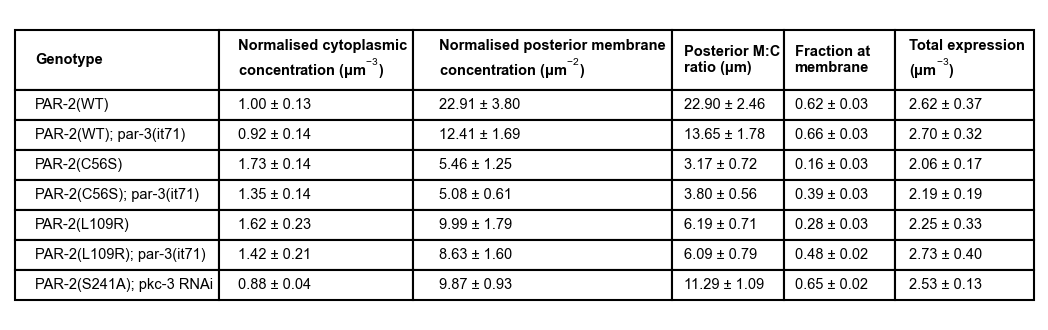

In [6]:
fig = plot_table(RESULTS_FULL)
fig.savefig("Figs/results_table.png", dpi=600, transparent=True)
fig.savefig("Figs/results_table.pdf", transparent=True)